<a href="https://colab.research.google.com/github/supremepoulet/github_actions/blob/main/3_Gender_detection_corrig%C3%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img src="https://assets-datascientest.s3-eu-west-1.amazonaws.com/train/logo_datascientest.png" style="height:150px;center"></center>

<hr style="border-width:2px;border-color:#75DFC1">
<center><h1>Deep-Learning - Modules complémentaires</h1></center>
<center><h2>Détection du genre d'une personne avec son visage</h2></center>
<hr style="border-width:2px;border-color:#75DFC1">


Le but de cet exercice est de s'exercer à faire des classifications avec des CNN.

 Nous allons travailler avec la base de données **```age_gender.csv```**. Cette base contient des images de visages, ainsi que le genre et l'âge de la personne en question.

 Notez que les images sont stockées dans le DataFrame sous forme de string facilement convertibles en tableau ```numpy``` de taille 48*48. Chaque élément du tableau représente la valeur du pixel de l'image (l'image est donc en noir et blanc).

> La structure de l'exercice est la suivante :
>> I - [Préparation du dataset](#preparation)
>>> A - [Premiers traitements](#preli)
>>>
>>>
>>> B - [Générateurs](#generateurs)
>>
>>
>> II - [Classification du genre](#gender)

- Exécuter les cellules ci-dessous pour importer le dataset et les modules nécessaires à l'exercice.

In [ ]:
!wget https://assets-datascientest.s3-eu-west-1.amazonaws.com/datasets/age_gender.zip
!unzip age_gender.zip

--2021-04-23 14:24:39--  https://assets-datascientest.s3-eu-west-1.amazonaws.com/datasets/age_gender.zip
Resolving assets-datascientest.s3-eu-west-1.amazonaws.com (assets-datascientest.s3-eu-west-1.amazonaws.com)... 52.218.24.184
Connecting to assets-datascientest.s3-eu-west-1.amazonaws.com (assets-datascientest.s3-eu-west-1.amazonaws.com)|52.218.24.184|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66099409 (63M) [application/zip]
Saving to: ‘age_gender.zip’

age_gender.zip      100%[===================>]  63.04M  22.2MB/s    in 2.8s    

2021-04-23 14:24:42 (22.2 MB/s) - ‘age_gender.zip’ saved [66099409/66099409]

Archive:  age_gender.zip
  inflating: age_gender.csv          


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

# I - <a name="preparation"></a> Préparation du dataset

## A - <a name="preli"></a> Premiers traitements

- (a) Exécuter la cellule suivante pour importer le jeu de données dans un DataFrame ```df``` et convertir la colonne ```pixels``` en tableau ```numpy```.

In [ ]:
df = pd.read_csv('age_gender.csv', sep=';')
df['pixels'] = df['pixels'].apply(lambda x : np.array(x.split()).astype(np.int16))

- (b) Afficher la shape de ```df``` ainsi que ses 5 premières lignes.

In [ ]:
print("Nombre de lignes dans le dataset : {}".format(df.shape[0]))
print("Nombre de colonnes dans le dataset : {}".format(df.shape[1]))

df.head()

Nombre de lignes dans le dataset : 23705
Nombre de colonnes dans le dataset : 3


,age,gender,pixels
0,1,0,"[129, 128, 128, 126, 127, 130, 133, 135, 139, ..."
1,1,0,"[164, 74, 111, 168, 169, 171, 175, 182, 184, 1..."
2,1,0,"[67, 70, 71, 70, 69, 67, 70, 79, 90, 103, 116,..."
3,1,0,"[193, 197, 198, 200, 199, 200, 202, 203, 204, ..."
4,1,0,"[202, 205, 209, 210, 209, 209, 210, 211, 212, ..."


- (c) Afficher une / des image(s) du dataset avec le genre de la personne associée.
> - Choisir un indice aléatoire et utiliser la fonction ```imshow``` en précisant ```cmap="gray"```
>
> - 0 correspond aux hommes et 1 aux femmes

In [ ]:
dict = {0 : 'H', 1 : 'F'}

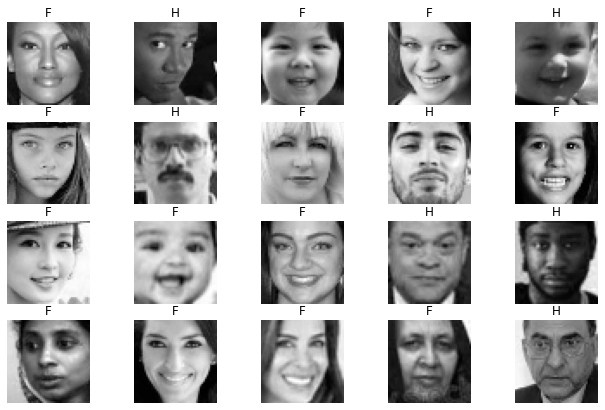

In [ ]:
fig, axs = plt.subplots(4, 5, figsize=(11, 7))

for row in range(4):
  for col in range(5):
    indice = np.random.randint(df.shape[0])
    axs[row, col].imshow(df['pixels'][indice].reshape((48, 48)), cmap="gray")
    axs[row, col].set_title(dict[df['gender'][indice]])
    axs[row, col].axis('off')

Le dataset contient des images d'enfants en bas âge, dont il peut être difficile de discerner le genre.
- (d) Supprimer de ```df``` les personnes de moins de 10 ans.
> - Réinitialiser l'index de ```df```, ceci nous sera utile dans la suite

In [ ]:
df = df[df['age'] > 10].reset_index(drop=True)

- (e) Afficher la répartition de la colonne ```gender``` avec un graphe de votre choix.

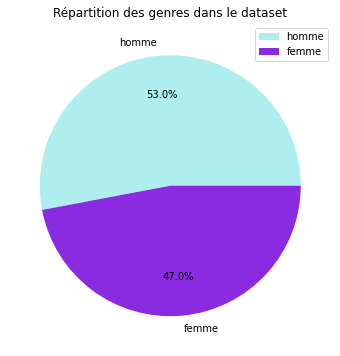

In [ ]:
plt.figure(figsize=(12,6))

plt.pie(df.gender.value_counts(),
        labels=['homme', 'femme'],
        colors=['paleturquoise', 'blueviolet'],
        autopct='%1.1f%%',
        pctdistance=0.7)
plt.title('Répartition des genres dans le dataset')
plt.legend();

- (f) Exécuter la cellule suivante pour séparer les variables explicatives des variables cibles. (prêtez une attention particulière aux dimensions de ```X```)

In [ ]:
X = []
for i in range(df.shape[0]):
  X = np.append(X, df['pixels'][i])
X = X.reshape(df.shape[0], 48, 48, 1)

y = df['gender'].values

- (g) Séparer ```X``` et ```y``` en un jeu de test et d'entraînement.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## B - <a name="generateurs"></a> Générateurs

- (h) Définir deux générateurs ```train_data_generator``` et ```test_data_generator``` avec les caractéristiques de votre choix.
> - On peut notamment scaler les données en divisant chaque pixel par 255

In [ ]:
train_data_generator = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=1,
        height_shift_range=1,
        zoom_range=[0.7, 1.2],
        rescale=1/255,
        horizontal_flip=True)

test_data_generator = ImageDataGenerator(
    rescale=1/255)

- (i) Utiliser la méthode ```random_transform``` pour afficher à quoi ressemblent les données augmentées.

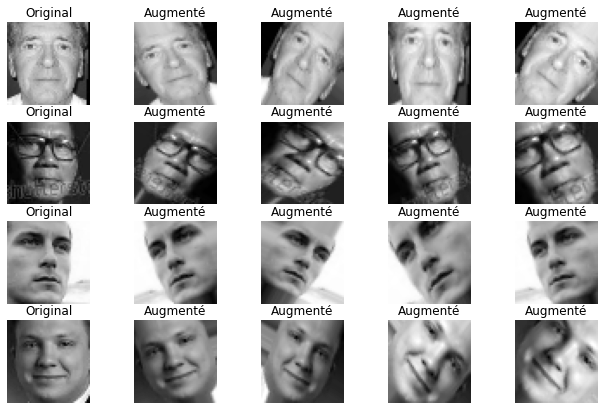

In [ ]:
fig, axs = plt.subplots(4, 5, figsize=(11, 7))

for row in range(4):
  indice = np.random.randint(X_train.shape[0])
  axs[row, 0].imshow(X_train[indice].reshape(48, 48), cmap="gray")
  axs[row, 0].set_title("Original")
  axs[row, 0].axis('off')
  for col in range(1, 5):
    axs[row, col].imshow(train_data_generator.random_transform(X_train[indice]).reshape(48, 48), cmap="gray")
    axs[row, col].set_title("Augmenté")
    axs[row, col].axis('off')

- (j) Implémenter sous les noms ```training_data``` et ```test_data``` des itérateurs des objets ```train_data_generator``` et ```test_data_generator``` ( utiliser la méthode ```flow```).
> - On choisira des lots de données (batchs) de taille 32.

In [ ]:
batch_size = 32

training_data = train_data_generator.flow(X_train, y_train, batch_size=batch_size)
test_data = test_data_generator.flow(X_test, y_test, batch_size=batch_size)

# II - <a name="gender"></a> Classification du genre

- (a) Instancier un réseau de neurones de l'architecture de votre choix.

- (b) Compiler le modèle avec une métrique appropriée.

- (c) Entraîner le modèle avec les paramètres de votre choix. On pourra également définir des callbacks.

- (d) Effectuer une prédiction à partir des données de test (attention au scaling si vous en avez défini un dans votre générateur).

- (e) Afficher des prédictions avec la fonction ```imshow```.

In [ ]:
input_shape = (48,48,1)

In [ ]:
model = Sequential()
model.add(Conv2D(filters=30, kernel_size=(5, 5), padding='valid', input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(rate=0.2))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.2))
model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                        patience = 8,
                        mode = 'min',
                        restore_best_weights = True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                            patience=4,
                            factor=0.5,
                            verbose=2,
                            mode='min')

In [ ]:
history = model.fit_generator(generator = training_data,
                              epochs = 100,
                              steps_per_epoch = len(X_train)//batch_size,
                              validation_data = test_data,
                              validation_steps = len(X_test)//batch_size,
                              callbacks = [early_stopping,lr_plateau])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
512/512 [==============================] - 41s 78ms/step - loss: 0.6606 - accuracy: 0.5780 - val_loss: 0.5338 - val_accuracy: 0.7329
Epoch 2/100
512/512 [==============================] - 40s 78ms/step - loss: 0.5470 - accuracy: 0.7303 - val_loss: 0.4459 - val_accuracy: 0.7944
Epoch 3/100
512/512 [==============================] - 39s 77ms/step - loss: 0.5057 - accuracy: 0.7544 - val_loss: 0.4176 - val_accuracy: 0.8093
Epoch 4/100
512/512 [==============================] - 38s 75ms/step - loss: 0.4736 - accuracy: 0.7756 - val_loss: 0.3615 - val_accuracy: 0.8464
Epoch 5/100
512/512 [==============================] - 39s 76ms/step - loss: 0.4430 - accuracy: 0.7952 - val_loss: 0.3785 - val_accuracy: 0.8289
Epoch 6/100
512/512 [==============================] - 38s 75ms/step - loss: 0.4301 - accuracy: 0.8035 - val_loss: 0.3255 - val_accuracy: 0.8652
Epoch 7/100
512/512 [==============================] - 39s 77ms/step - loss: 0.4228 - accuracy: 0.8066 - val_loss: 0.4081 - val_ac

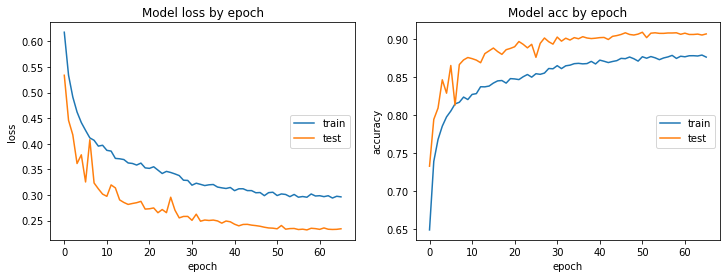

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right');

In [ ]:
y_pred = model.predict(X_test/255).round()

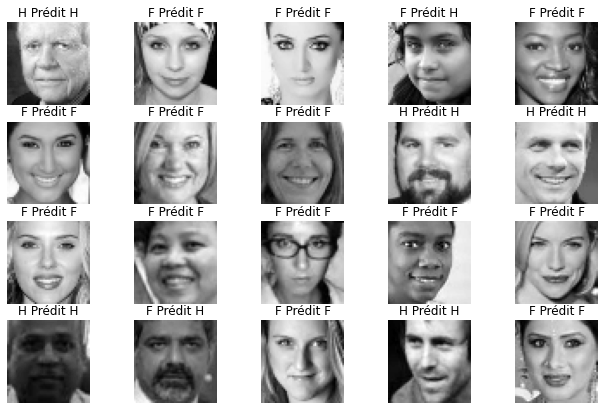

In [ ]:
fig, axs = plt.subplots(4, 5, figsize=(11, 7))

for row in range(4):
  for col in range(5):
    indice = np.random.randint(X_test.shape[0])
    axs[row, col].imshow(X_test[indice].reshape((48, 48)), cmap="gray")
    axs[row, col].axis('off')
    axs[row, col].set_title('{} Prédit {}'.format(dict[y_test[indice]], dict[y_pred[indice][0]]))